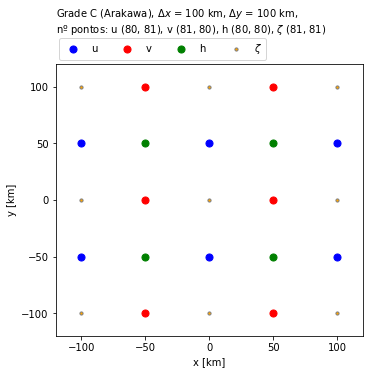

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
%matplotlib inline
import os 

dx = 100*1e3   # m
dy = 100*1e3   # m

#Grade C
x2 = np.arange(-4000*1e3, 4000*1e3 + dx, dx)
y2 = np.arange(-4000*1e3, 4000*1e3 + dy, dy)
x = (x2[1:] + x2[:-1])/2
y = (y2[1:] + y2[ :-1])/2

Xu, Yu = np.meshgrid(x2, y)
Xv, Yv = np.meshgrid(x, y2)
Xh, Yh = np.meshgrid(x,  y)
Xz, Yz = np.meshgrid(x2,y2)

# Plot Grid C
fig, ax = plt.subplots(1, figsize=(5.5,5), gridspec_kw={'hspace':0.05})
ax.scatter(Xu/1000, Yu/1000, color='blue', marker='.', s=200,label='u', edgecolors='b')
ax.scatter(Xv/1000, Yv/1000, color='red' , marker='.', s=200,label='v', edgecolors='r')
ax.scatter(Xh/1000, Yh/1000, color='green', marker='.', s=200,label='h', edgecolors='g')
ax.scatter(Xz/1000, Yz/1000, color='orange', marker='.', s=40, label='$\zeta$', edgecolors='0.5')
ax.set_xlabel('x [km]',fontsize=10)
ax.set_ylabel('y [km]',fontsize=10)
ax.legend(ncol=4, bbox_to_anchor=(0.7, 1.115), fontsize=10)
ax.set_xlim(-120, 120)
ax.set_ylim(-120, 120)
ax.set_title("Grade C (Arakawa), $\Delta x$ = {:.0f} km, $\Delta y$ = {:.0f} km,\nnº pontos: u ".format(dx/1000, dy/1000)+ f"{Xu.shape}, v {Xv.shape}, h {Xh.shape}, $\zeta$ {Xz.shape}\n\n", 
                fontsize= 10, loc='left')
fig.savefig("fig/GridC_ex5.png", dpi=300, bbox_inches='tight', facecolor='w')


In [2]:
# Define constants
# ------------------------------------------
H, days, dt = 10, 100, 60

Tf = days*24*3600                         # final time
t = np.arange(0, Tf, dt)
q = 2*np.pi/86400                         # angular velocity (2pi/(24*3600 s)) [1/s]
a = 6371000                               # Earth radius [m]
g = 9.8                                   # m/s^2 (gravity acceleration)
c = np.sqrt(g*H)                          # Phase velocity [m/s]
beta = 2*q*np.cos(np.deg2rad(0))/a        # Plano Beta equatorial     
fu = beta*Yu
fv = beta*Yv

# We define initial conditions and variables
""" time definitions
<var>nm1  (n-1)
<var>n    ( n )
<var>np1  (n+1) 
"""

# time (n-1)
unm1, vnm1, hnm1  = np.zeros(Xu.shape), np.zeros(Xv.shape), np.zeros(Xh.shape)
# time ( n )
un  , vn  , hn    = np.zeros(Xu.shape), np.zeros(Xv.shape), np.zeros(Xh.shape)
# time (n+1)
unp1, vnp1, hnp1  = np.zeros(Xu.shape), np.zeros(Xv.shape), np.zeros(Xh.shape)

# Source conditional for zonal wind and height
# ------------------------------------------------------------------------------
amp = 1
alfa = 0.02
Fu = amp*np.exp(-(Yu-0*dy)**2/(4*dy)**2)*np.exp(-(Xu-15*dx)**2/(10*dx)**2)/(24*3600)
Fh = 10*np.exp(-Xh**2/(4*dx)**2 - Yh**2/(10*dy)**2)

dec = (alfa**6) * t[::-1]/(3600*24)**2 * np.exp(-alfa*(t/(3600*24)))
dec = dec/np.nanmax(dec)
un   += Fu*dec[0]
hn   += H #+ Fh
hnm1 += H #+ Fh
hnp1 += H #+ Fh

# Sampling variables each sample_interval
# ---------------------------------------
h_lst = list()                                     # h sampling
u_lst = list(); v_lst = list()                     # u, v sampling
div_lst = list(); vor_lst = list()                 # divergence and vorticity
t_lst  = [0]
sample_interval = 60*24                            # Time to save information [min]
h_lst.append(hn)
u_lst.append(un)
v_lst.append(vn)

U, V = un.copy(), vn.copy()
mass   = np.array([])                              # mass conservation
en_k   = np.array([])                              # kinetic energy
en_p   = np.array([])                              # potential energy
enst   = np.array([])                              # enstrophy energy

time_step = 0

for n in range(1, t.shape[0]):
    """Shallow water equations linearized
    U: Mass flux U
    V: Mass flux V
    B: Bernoulli defined at the locations where h is defined
    Zeta: absolute potential vorticity is redefined to the corners of th C-grid
    """
	# Mass fluxes U and V at inside points related to h
    # -------------------------------------------------
    # Mass flux in U
    U = un.copy()*np.nan
    U[:,1:-1] = un[:,1:-1] * 1/2*(hn[:, :-1] + hn[:, 1:])
    U[:,   0] = un[: ,0] * hn[:,0]
    U[:,  -1] = un[:,-1] * hn[:,-1]

	# Mass flux in V
    V = vn.copy()*np.nan
    V[1:-1, :] = vn[1:-1, :] * 1/2*(hn[:-1, :]+hn[1:, :])
    V[0   , :] = vn[  0, :] * hn[0 , :]
    V[-1  , :] = vn[ -1, :] * hn[-1, :]

    # Bernoulli (ok)
    # ----------------------------------------------------------------------------------------
    B = (g*hn + 1/2 * (1/2*(un[: , 1:]**2 + un[:, :-1]**2) + 
                       1/2*(vn[1:,  :]**2 + vn[:-1, :]**2)))

	# ZETA - absolute potential vorticity
    # ----------------------------------------------------------------------------------------
    ZETA = np.ones((Xz.shape[0], Yz.shape[1]))*np.nan
    # Inside points -> E = (f + dv/dx - du/dy)/h
    ZETA[1:-1, 1:-1] = ((fv[1:-1, :-1] + (vn[1:-1, 1:] - vn[1:-1, :-1])/dx - (un[1:, 1:-1] - un[:-1, 1:-1])/dy) / 
                        ((hn[:-1, :-1] + hn[:-1, 1:] + hn[1:, :-1] + hn[1:, 1:])/4))
    
	# South - North [0, -1] in v (Y axis)
    ZETA[ 0, 1:-1] = (fv[ 0, :-1] + (vn[ 0, 1:] - vn[0 , :-1])/dx) / ((hn[ 0, :-1] + hn[ 0, 1:])/2) 
    ZETA[-1, 1:-1] = (fv[-1, :-1] + (vn[-1, 1:] - vn[-1, :-1])/dx) / ((hn[-1, :-1] + hn[-1, 1:])/2)
    
	# East - West [0, -1] in u (X axis)
    ZETA[1:-1, 0] = (fv[1:-1, 0] - (un[1:, 0] - un[:-1 , 0])/dy) / ((hn[:-1, 0] + hn[1:, 0])/2) 
    ZETA[1:-1,-1] = (fv[1:-1,-1] - (un[1:,-1] - un[:-1 ,-1])/dy) / ((hn[:-1,-1] + hn[1:,-1])/2) 

	# Iterations as leap-frog scheme
    # -----------------------------------------------------------------------------------------
    unp1[:   , 1:-1] = (unm1[:,1:-1] + 2*dt*(1/2*(ZETA[1: , 1:-1]* 1/2 *(V[1: , :-1] + V[1: , 1:]) + 
                                                  ZETA[:-1, 1:-1]* 1/2 *(V[:-1, :-1] + V[:-1, 1:])) - 
                                             (B[:, 1:] -B[:, :-1])/dx + Fu[:, 1:-1] * dec[n]))
    
    vnp1[1:-1,:    ] = (vnm1[1:-1,:] - 2*dt*(1/2*(ZETA[1:-1,  1:]* 1/2 *(U[:-1,  1:] + U[1:, 1:]) +
                                                  ZETA[1:-1, :-1]* 1/2 *(U[:-1, :-1] + U[1:,:-1])) + 
                                             (B[1:, :] - B[:-1, :])/dy))
    
    hnp1[:, :]       = (hnm1[:,:] + 2*dt*(-(U[:, 1:] - U[:, :-1])/dx - (V[1:, :] - V[:-1, :])/dy))
    
    # Boundary conditions (radiational and rigid at east)
    # ------------------------------------------------------------------------------------------
    # East -> du/dt - fv + c*du/dx = 0
    unp1[:,-1] = 0
    
	# West -> du/dt - fv - c*du/dx = 0    (radiational)
    unp1[: , 0] = un[: , 0] + dt*((vn*fv)[1: , 0] + (vn*fv)[:-1, 0])/2 + c*dt/dx * (un[:, 1] - un[:, 0])

	# South -> dv/dt + fu - c*dv/dy = 0   (radiational)
    vnp1[0 , :] = vn[0 , :] - dt*((un*fu)[0,  1:] + (un*fu)[0, :-1])/2 + c*dt/dx * (vn[1, :] - vn[0, :])

	# North -> dv/dt + fu + c*dv/dy = 0   (radiational)
    vnp1[-1, :] = vn[-1, :] - dt*((un*fu)[0,  1:] + (un*fu)[0, :-1])/2 - c*dt/dx * (vn[-1,:] - vn[-2, :])

	# Loop
    # ----------------------------------------------------------------------
    # n   -> n-1
    unm1 = un.copy()
    vnm1 = vn.copy()
    hnm1 = hn.copy()
    
    # n+1 -> n
    un = unp1.copy()
    vn = vnp1.copy()
    hn = hnp1.copy()

    # Divergence and vorticity
    # ----------------------------------------------------------------------    
    uplot = (un[: ,1:] + un[:  , :-1])/2
    vplot = (vn[1:, :] + vn[:-1,   :])/2
    
    div = (un[:,1:] - un[:, :-1])/dx + (vn[1:, :] - vn[:-1, :])/dy
    vor = np.gradient(vplot, axis=1)/dx - np.gradient(uplot, axis=0)/dy

    # Mass & energy conservation
    # ----------------------------------------------------------------------
    mass = np.concatenate((mass, [np.nansum(hn * dx*dy)]))
    en_p = np.concatenate((en_p, [g/2 * np.nansum((hn**2) * dx*dy)]))
    en_k = np.concatenate((en_k, [H/2 *(np.nansum((un**2) * dx*dy) + 
                                        np.nansum((vn**2) * dx*dy))]))
    
    enst = np.concatenate((enst, [np.nansum(vor**2)]))
        
    time_step += 1
    
    if (time_step % sample_interval == 0):
        print("Time: \t{:.2f} hours".format(time_step*dt/3600))
        print("Sample interval (days): \t{} / {:.0f}".format(time_step/sample_interval+1, Tf/(24*60*dt)))
        print("Mass: \t{:.2f}\n".format(np.sum(hn)))
        h_lst.append(hn)
        u_lst.append(un)
        v_lst.append(vn)
        div_lst.append(div)
        vor_lst.append(vor)
        t_lst.append(time_step*dt)        # seconds


Time: 	24.00 hours
Sample interval (days): 	2.0 / 100
Mass: 	64000.00

Time: 	48.00 hours
Sample interval (days): 	3.0 / 100
Mass: 	64000.00

Time: 	72.00 hours
Sample interval (days): 	4.0 / 100
Mass: 	64000.00

Time: 	96.00 hours
Sample interval (days): 	5.0 / 100
Mass: 	64000.01

Time: 	120.00 hours
Sample interval (days): 	6.0 / 100
Mass: 	63999.94

Time: 	144.00 hours
Sample interval (days): 	7.0 / 100
Mass: 	63996.35

Time: 	168.00 hours
Sample interval (days): 	8.0 / 100
Mass: 	63980.96

Time: 	192.00 hours
Sample interval (days): 	9.0 / 100
Mass: 	63952.89

Time: 	216.00 hours
Sample interval (days): 	10.0 / 100
Mass: 	63923.23

Time: 	240.00 hours
Sample interval (days): 	11.0 / 100
Mass: 	63901.79

Time: 	264.00 hours
Sample interval (days): 	12.0 / 100
Mass: 	63879.04

Time: 	288.00 hours
Sample interval (days): 	13.0 / 100
Mass: 	63864.46

Time: 	312.00 hours
Sample interval (days): 	14.0 / 100
Mass: 	63850.17

Time: 	336.00 hours
Sample interval (days): 	15.0 / 100
Mass: 	

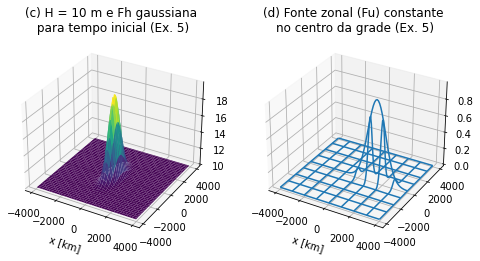

In [3]:
# set up a figure twice as wide as it is tall
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.plot_surface(Xh/1000, Yh/1000, Fh+H, cmap='viridis', edgecolor='none')
# ax.set_zlim(249, 260)
ax.set_xlabel('x [km]')
ax.set_title(f'(c) H = {H} m e Fh gaussiana\n para tempo inicial (Ex. 5)')

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_wireframe(Xu/1000, Yu/1000, Fu*86400, rstride=10, cstride=10)
ax.set_title('(d) Fonte zonal (Fu) constante \nno centro da grade (Ex. 5)')
ax.set_xlabel('x [km]')
plt.show()
fig.savefig("fig/fonte_ex5.png", dpi=300, bbox_inches='tight', facecolor='w')

## Time evolution

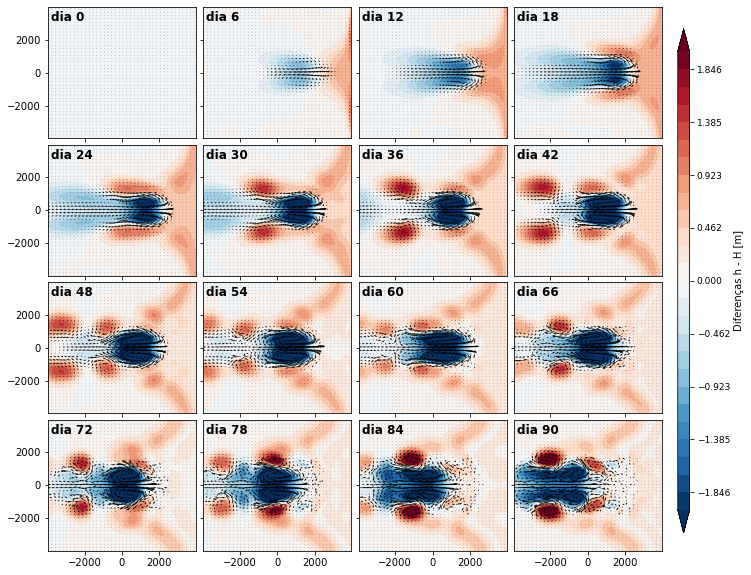

In [6]:
staged_u = np.zeros(Xh.shape)
staged_v = np.zeros(Xh.shape)
pts =2
arr3 = 0.005
scen = 'scen3'

fig, axes = plt.subplots(4,4, figsize=(11,10), sharex = True, sharey=True, 
                         gridspec_kw={'hspace':0.05, 'wspace':0.05} )
for ax, npass in zip(axes.flatten(), range(0,25*6, 6)):
    npass = int(npass)
    im = ax.contourf(Xh/1000, Yh/1000, h_lst[npass]-H, levels=np.linspace(-2,2,27),
                     extend='both', cmap=plt.cm.RdBu_r)
    ax.set_title("dia {:.0f}".format(t_lst[npass]/(3600*24)), y =1, x =0.02, pad=-14, loc="left", fontweight='bold')
    
    u, v = u_lst[npass], v_lst[npass]
    staged_u[ :, :] = (u[ :, 1:] + u[ :, :-1]) * 0.5
    staged_v[ :, :] = (v[ 1:, :] + v[:-1, : ]) * 0.5
    
    Q = ax.quiver(Xh[::pts, ::pts]/1000, Yh[::pts, ::pts]/1000,
                  staged_u[::pts, ::pts], staged_v[::pts, ::pts],
                  units = "xy", scale = arr3, width = 30)
    #fig.colorbar(im, ax=ax)
# cax = fig.add_axes([.2,.07,0.6,.02]) # left, bottom, width, height (horizontal)
cax = fig.add_axes([.92,.15,0.015,.7]) # left, bottom, width, height (horizontal)
cbar = fig.colorbar(im, cax=cax, orientation='vertical') # pad, shrink
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_ylabel('Diferenças h - H [m]')
fig.savefig("fig/lf_ex5_"+str(H)+"m_"+scen+"_Fu.png", dpi = 300, bbox_inches='tight', facecolor='w')

In [5]:
# Animation
# ---------
lvs1 = list(np.linspace(-1, 1, 16*2+1))
lvs2 = list(np.linspace(-1, 1, 16*2+1))
lvs3 = list(np.linspace(-1, 1, 16*2+1))
lvs = {'scen1': lvs1, 'scen2':lvs2, 'scen3':lvs3}
scen = 'scen3'
arr3 = 0.005 # arrows size
pts = 4
staged_u = np.zeros(Xh.shape)
staged_v = np.zeros(Xh.shape)

filenames = []

for n in range(0, len(h_lst)):
    fig, ax = plt.subplots()


    arrows = {'scen1': 0.001, 'scen2':0.001, 'scen3':0.001}
    im = ax.contourf(Xh/1000, Yh/1000, h_lst[int(n)]-H, 
                    cmap = plt.cm.RdBu_r, 
                    levels = lvs[scen], extend='both')
        
    cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_ylabel('h - H [m]', fontsize=8)
    ax.set_title("t={:.0f} dias".format(t_lst[int(n)]/(24*3600)),  
                 fontsize=10, loc='left')
    ax.set_xlim(-4000, 4000)
    ax.set_ylim(-4000, 4000)

    u, v = u_lst[n], v_lst[n]
    staged_u[ :, :] = (u[ :, 1:] + u[ :, :-1]) * 0.5
    staged_v[ :, :] = (v[ 1:, :] + v[:-1, : ]) * 0.5
    
    Q = ax.quiver(Xh[::pts, ::pts]/1000, Yh[::pts, ::pts]/1000,
                  staged_u[::pts, ::pts], staged_v[::pts, ::pts],
                  units = "xy", scale = arr3, width = 30)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)
    plt.close() # build gif

    # save frame
    fig.savefig(filename, dpi=200)

    ngif = 'gifs/lf_ex5_'+str(H)+'m_'+scen+'_Fu.gif'

    with imageio.get_writer(ngif, mode='I', duration = .5) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
         
# Remove files
for filename in set(filenames):
    os.remove(filename) 
print(f"Execution of animation done for {scen}.")

Execution of animation done for scen3.


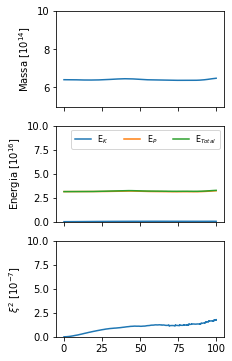

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(3, 6), sharex=True,
                         gridspec_kw={'wspace':0.25})
t_dias = t[1:]/(24*60*60)
ax[0].plot(t_dias, mass/1e14, label='Massa')
ax[0].set_ylabel('Massa [10$^{14}]$')
ax[0].set_ylim(5,10)

ax[1].plot(t_dias, en_k/1e16, label='E$_K$')
ax[1].plot(t_dias, en_p/1e16, label='E$_P$')
ax[1].plot(t_dias, (en_k+en_p)/1e16, label='E$_{Total}$')
ax[1].set_ylabel('Energia [10$^{16}]$')
ax[1].set_ylim(0,10)
ax[1].legend(fontsize=8, ncol=3)

ax[2].plot(t_dias, enst/1e-7, label='E$_K$')
ax[2].set_ylabel('$\\xi ^2$ [10$^{-7}]$')
ax[2].set_ylim(0,10)

fig.savefig("fig/lf_ex5_vol_ener_Fhu"+str(H)+"m.png", dpi = 300, bbox_inches='tight', facecolor='w')

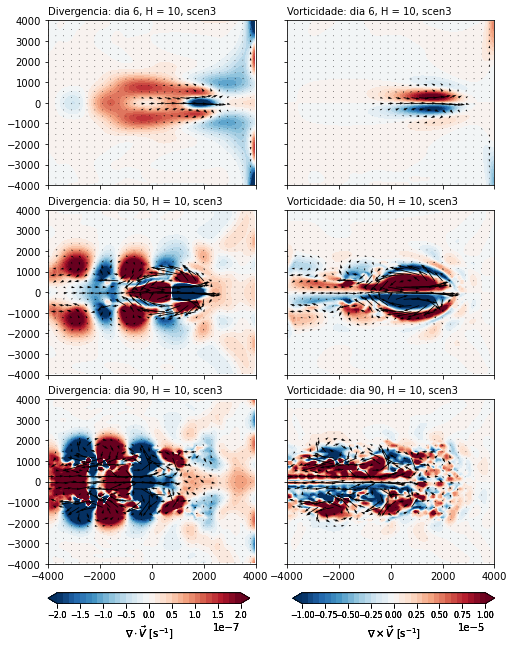

In [28]:
# Divergence & Vorticity
# ----------------------
lvs1 = list(np.linspace(-2e-7, 2e-7, 2*16+1))
lvs2 = list(np.linspace(-1e-5, 1e-5, 2*16+1))
title = 'Beta equatorial'
scen = 'scen3'
nidx = [6, 50, 90]
pts=3
arr3 = 0.004
    
fig, axes = plt.subplots(3,2, figsize=(8,10), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
# Divergencia
# -----------
for n, ax in zip(nidx, [axes[0,0], axes[1,0], axes[2,0]] ):
    im = ax.contourf(Xh/1000,Yh/1000, div_lst[n], levels=lvs1, cmap=plt.cm.RdBu_r, extend='both') #,
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    # u, v = data[scen]['u'], data[scen]['v']
    # staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    # staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(Xu[::pts, ::pts]/1000, Yu[::pts, ::pts]/1000, 
                 u_lst[n][::pts, ::pts], v_lst[n][::pts, ::pts],
                 units = "xy", scale = arr3, width = 35, color='k')
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_xlim(-4000, 4000)
    ax.set_ylim(-4000, 4000)
    ax.set_title("Divergencia: dia {:.0f}, H = {:.0f}, ".format(t_lst[n]/(3600*24),  H)+scen, fontsize=10, loc='left')
    cax = fig.add_axes([.125,.07,0.35,.015]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xlabel('$\\nabla \\cdot \\vec{V}$'+' [s$^{-1}$]')
    
# Vorticidade
# -----------
for n, ax in zip(nidx, [axes[0,1], axes[1,1], axes[2,1]]):
    im = ax.contourf(Xh/1000,Yh/1000, vor_lst[n], levels=lvs2, cmap=plt.cm.RdBu_r,  extend='both') #levels=lvs,
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    Q = ax.quiver(Xu[::pts, ::pts]/1000, Yu[::pts, ::pts]/1000, 
                u_lst[n][::pts, ::pts], v_lst[n][::pts, ::pts],
                units = "xy", scale = arr3, width = 35, color='k')
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_xlim(-4000, 4000)
    ax.set_ylim(-4000, 4000)
    ax.set_title("Vorticidade: dia {:.0f}, H = {:.0f}, ".format(t_lst[n]/(3600*24),  H)+scen, fontsize=10, loc='left')
    cax = fig.add_axes([.55,.07,0.35,.015]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xlabel('$\\nabla \\times \\vec{V}$'+' [s$^{-1}$]')

fig.savefig("fig/lf_ex5_div_vor"+str(H)+"m_"+scen+".png", dpi = 300, bbox_inches='tight', facecolor='w')